<a href="https://colab.research.google.com/github/lucasbegue/clases-ML/blob/main/notebook_clase2_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [1]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

# Datos

Descargar el archivo 'meatspec.csv' de la carpeta 'datasets' del drive. Despues subirlo a esta notebook.


El departamento de calidad de una empresa de alimentación se encarga de medir el contenido en grasa de la carne que comercializa. El proceso de medición de grasa es costoso en tiempo y recursos. Una alternativa que permitiría reducir costos y tiempo es emplear un espectrofotómetro (instrumento capaz de detectar la absorbancia que tiene un material a diferentes tipos de luz) e inferir el contenido en grasa a partir de sus medidas.

Antes de dar por válida esta nueva técnica, la empresa necesita comprobar qué margen de error tiene respecto al análisis químico. Para ello, se mide el espectro de absorbancia a 100 longitudes de onda en 215 muestras de carne, cuyo contenido en grasa se obtiene también por análisis químico, y se entrena un modelo con el objetivo de predecir el contenido en grasa a partir de los valores dados por el espectrofotómetro.

In [2]:
# Datos
df = pd.read_csv('https://raw.githubusercontent.com/lucasbegue/clases-ML/main/datasets/meatspec.csv')
df.shape

(215, 101)

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


# Relación entre variables

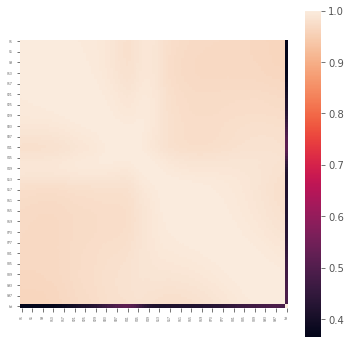

In [4]:
corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')

# Heatmap matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    corr_matrix, square=True, ax=ax
)
ax.tick_params(labelsize=3)

Vemos que las variables estan todas muy correlacionadas entre sí. En general se observan correlaciones absolutas >0.9, lo que implica un problema para modelos de regresión lineal. 

# Modelos

In [5]:
# División de los datos en train y test
X = df.drop(columns='fat')
y = df['fat']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.reshape(-1,1),
    train_size=0.7,
    random_state=23,
    shuffle=True
)

### Mínimos cuadrados (OLS)

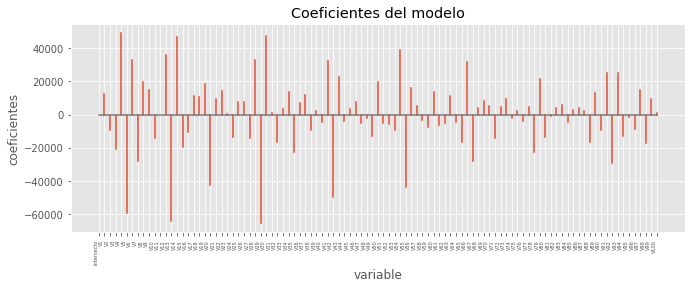

In [6]:
# Creación y entrenamiento del modelo
modelo = LinearRegression(normalize=True)
modelo.fit(X=X_train, y=y_train)
LinearRegression(normalize=True)

# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
    {
     'predictor': ['intersecto'] + list(X_train.columns.values),
     'coef': [modelo.intercept_] + list(modelo.coef_.flatten())
    }
)

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')
plt.show()

In [7]:
# Predicciones test
y_pred = modelo.predict(X=X_test)
y_pred = y_pred.flatten()

# Error de test del modelo 
rmse_ols = mean_squared_error(
    y_true  = y_test,
    y_pred  = y_pred,
    squared = False
)

print(f"El error (rmse) de test es: {rmse_ols}")

El error (rmse) de test es: 4.194959653329014


### Ridge

In [8]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
modelo = RidgeCV(
    alphas = np.logspace(-10, 2, 200), # prueba 200 valores en el intervalo [10^-10; 10^2]
    fit_intercept = True,
    normalize = True,
    store_cv_values = True
)

_ = modelo.fit(X = X_train, y = y_train)

Cuando utilizamos regularización, es interesante analizar cómo los coeficientes se acercan a cero cuando incrementamos alpha. 

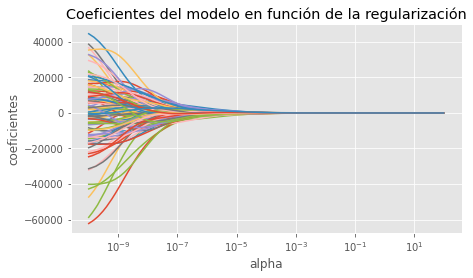

In [9]:
# Evolución de los coeficientes en función de alpha

alphas = modelo.alphas
coefs = []

for alpha in alphas:
  modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
  modelo_temp.fit(X_train, y_train)
  coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

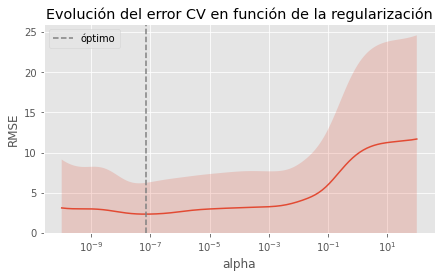

In [10]:
# Evolución del error en función de alpha
# modelo.cv_values_ almacena el mse de cv para cada valor de alpha.
# Tiene dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0) # mse promedio en las 150 observaciones
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)  # desvio estandar de mse

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse = np.min(rmse_cv)
sd_min_rmse = rmse_sd[np.argmin(rmse_cv)]
optimo = modelo.alphas[np.argmin(rmse_cv)]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x=optimo,
    c="gray",
    linestyle='--',
    label='óptimo'
)

ax.set_xscale('log')
ax.set_ylim([0, None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend(loc='upper left')
plt.show()

In [11]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 6.826071834272379e-08


In [12]:
# Predicciones test
y_pred = modelo.predict(X=X_test)
y_pred = y_pred.flatten()

# Error de test del modelo 
rmse_ridge = mean_squared_error(
    y_true = y_test,
    y_pred = y_pred,
    squared = False
)

print("")
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de test es: 2.2547136806720114


### Lasso

La regularización Lasso penaliza la suma del valor absolutos de los coeficientes de regresión. A esta penalización se le conoce como l1 y tiene el efecto de forzar a que los coeficientes de los predictores tiendan a cero. Dado que un predictor con coeficiente de regresión cero no influye en el modelo, lasso consigue excluir los predictores menos relevantes. El grado de penalización está controlado por el hiperparámetro alpha. Cuando alpha=0 el resultado es equivalente al de un modelo lineal por mínimos cuadrados ordinarios. A medida que alpha aumenta, mayor es la penalización y más predictores quedan excluidos.

In [13]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# Por defecto LassoCV utiliza el mean squared error
modelo = LassoCV(
    alphas = np.logspace(-10, 3, 200),
    normalize = True,
    cv = 10
)
_ = modelo.fit(X=X_train, y=y_train)

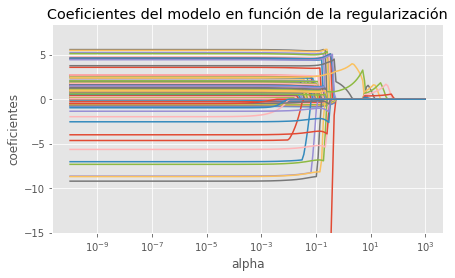

In [14]:
# Evolución de los coeficientes en función de alpha
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

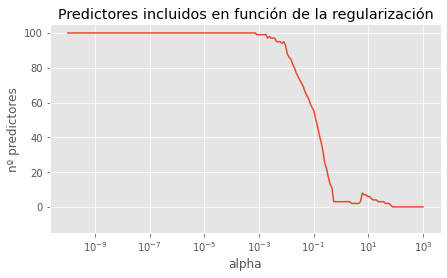

In [15]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

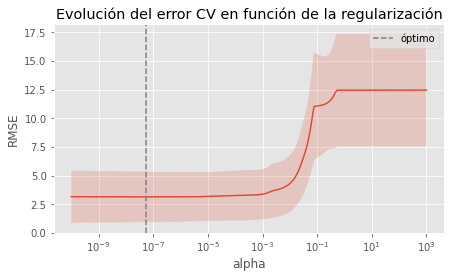

In [16]:
# Evolución del error en función de alpha
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha
# Tiene dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
optimo       = modelo.alphas_[np.argmin(rmse_cv)]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x = optimo,
    c = "gray",
    linestyle = '--',
    label = 'óptimo'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [17]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 5.5426645206631074e-08


In [18]:
y_pred = modelo.predict(X=X_test)
y_pred = y_pred.flatten()

# Error de test del modelo 
rmse_lasso = mean_squared_error(
    y_true = y_test,
    y_pred = y_pred,
    squared = False
)

print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 4.291888085076769


### Elastic Net

Elastic net incluye una regularización que combina la penalización l1 y l2. El grado en que influye cada una de las penalizaciones está controlado por el hiperparámetro  alpha. Su valor está comprendido en el intervalo [0,1]. Cuando  α=0, corresponde a Ridge y cuando  α=1 corresponde a Lasso. La combinación de ambas penalizaciones suele dar lugar a buenos resultados.

In [19]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# Por defecto ElasticNetCV utiliza el mean squared error
modelo = ElasticNetCV(
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
    alphas = np.logspace(-10, 3, 200),
    normalize = True,
    cv = 10
)

_ = modelo.fit(X = X_train, y = y_train)

In [20]:
# Evolución del error en función de alpha y l1_ratio
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
    data = mean_error_cv.flatten(),
    index = pd.MultiIndex.from_product(
        iterables = [modelo.l1_ratio, modelo.alphas_],
        names = ['l1_ratio', 'modelo.alphas_']
    ),
    columns = ["mse_cv"]
)

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
184,0.0,9.547716e-10,9.799961,3.130489
185,0.0,8.214344e-10,9.800044,3.130502
183,0.0,1.109752e-09,9.800066,3.130506
579,0.5,2.025502e-09,9.800197,3.130527
383,0.1,1.109752e-09,9.800200,3.130527
...,...,...,...,...
843,0.9,1.552225e+00,155.316276,12.462595
844,0.9,1.335452e+00,155.316276,12.462595
845,0.9,1.148951e+00,155.316276,12.462595
847,0.9,8.504489e-01,155.316276,12.462595


Text(0, 0.5, 'rmse_cv')

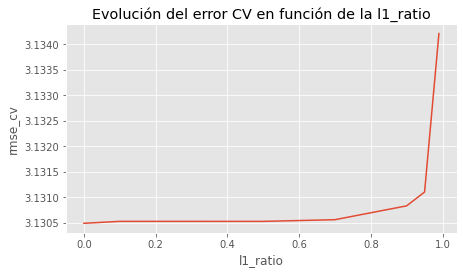

In [23]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv')

In [24]:
# Mejor valor alpha y l1_ratio_ encontrado
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 9.547716114208065e-10
Mejor valor de l1_ratio encontrado: 0.0


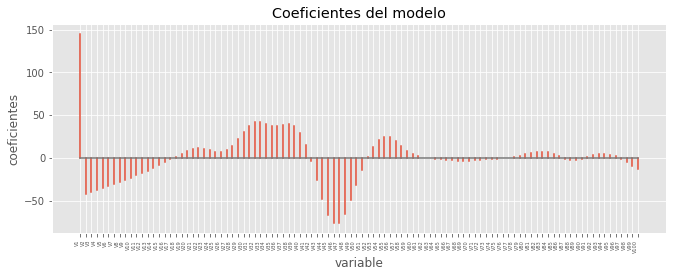

In [27]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [28]:
# Predicciones test
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
rmse_elastic = mean_squared_error(
    y_true  = y_test,
    y_pred  = predicciones,
    squared = False
)

print(f"El error (rmse) de test es: {rmse_elastic}")

El error (rmse) de test es: 4.29182179362882


### Comparacion de los modelos


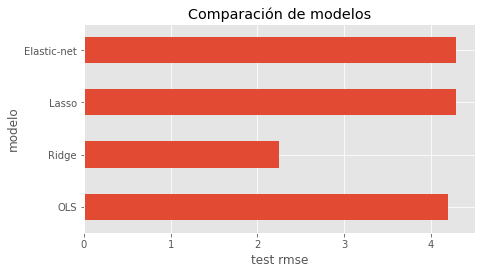

In [32]:
df_comparacion = pd.DataFrame(
    {
        'modelo': ['OLS', 'Ridge', 'Lasso', 'Elastic-net'],
        'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
    }
)

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', legend=None, ax=ax)
ax.set_xlabel('test rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos')
plt.show()